In [2]:
from datetime import datetime
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.covariance import EllipticEnvelope
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))

# Prep

In [4]:
dat = pd.read_csv("PROJECT_training2005/ufz_qc_challenge/00_data.csv", sep=" ")
dat.head()

,,Time,Box,Date.Time,SM1,SM1_Flag,Temp1,Temp1_Flag,SM2,SM2_Flag,Temp2,...,SM6_Flag,Temp6,Temp6_Flag,BattV,SM1_Depth,SM2_Depth,SM3_Depth,SM4_Depth,SM5_Depth,SM6_Depth
1.2,2012-07-19,17:45:53,1,2012-07-19 17:45:53,-2.8240,Auto:Range,18.2580,OK,-5.9817,Auto:Range,18.2232,...,Auto:Range,18.3623,OK,3599,0.05,0.05,0.05,0.05,0.05,0.05
2.2,2010-10-03,02:07:00,2,2010-10-03 02:07:00,29.9656,OK,5.0416,OK,-4.8066,Auto:Range,-15.1656,...,OK,5.7372,OK,3138,0.10,0.20,0.30,0.40,0.50,0.60
2.3,2010-10-03,03:07:00,2,2010-10-03 03:07:00,26.1448,OK,8.4848,OK,23.7972,OK,7.7544,...,Auto:Spike,6.8154,OK,3496,0.10,0.20,0.30,0.40,0.50,0.60
2.4,2010-10-06,05:08:00,2,2010-10-06 05:08:00,29.7645,OK,4.9373,OK,-4.7984,Auto:Range,-15.1656,...,OK,5.7024,OK,3198,0.10,0.20,0.30,0.40,0.50,0.60
2.5,2010-10-10,04:09:00,2,2010-10-10 04:09:00,29.9037,OK,5.0764,OK,-4.8066,Auto:Range,-15.1656,...,OK,5.7720,OK,3209,0.10,0.20,0.30,0.40,0.50,0.60


In [5]:
View(dat.sample(100))

## Cleaning

### Long data format with row for each sensor

In [6]:
littlesample = dat.sample(5)
labels = littlesample.columns.tolist()
labels

def allLabelsExcept(vector):
    c = []
    for i in range(0, len(labels)):
        if (labels[i] not in vector):
            c.append(labels[i])
    return(c)

#### Long dataframe (DF) for Sensors

In [7]:
cSM = []
for i in range(1, 7):
    thisLabel = "SM" + str(i)
    cSM.append(thisLabel)
        
print("c:{}".format(cSM))
print("cNoSM:{}".format(allLabelsExcept(cSM)))

dfSensor = pd.melt(dat, value_vars=cSM, id_vars=allLabelsExcept(cSM), var_name="Sensor", value_name="SM")
dfSensor = dfSensor[["Box", "Date.Time", "BattV", "Sensor", "SM"]]
dfSensor

c:['SM1', 'SM2', 'SM3', 'SM4', 'SM5', 'SM6']
cNoSM:['Time', 'Box', 'Date.Time', 'SM1_Flag', 'Temp1', 'Temp1_Flag', 'SM2_Flag', 'Temp2', 'Temp2_Flag', 'SM3_Flag', 'Temp3', 'Temp3_Flag', 'SM4_Flag', 'Temp4', 'Temp4_Flag', 'SM5_Flag', 'Temp5', 'Temp5_Flag', 'SM6_Flag', 'Temp6', 'Temp6_Flag', 'BattV', 'SM1_Depth', 'SM2_Depth', 'SM3_Depth', 'SM4_Depth', 'SM5_Depth', 'SM6_Depth']


,Box,Date.Time,BattV,Sensor,SM
0,1,2012-07-19 17:45:53,3599,SM1,-2.8240
1,2,2010-10-03 02:07:00,3138,SM1,29.9656
2,2,2010-10-03 03:07:00,3496,SM1,26.1448
3,2,2010-10-06 05:08:00,3198,SM1,29.7645
4,2,2010-10-10 04:09:00,3209,SM1,29.9037
...,...,...,...,...,...
39860191,40,2019-05-12 07:57:21,3386,SM6,45.3140
39860192,40,2019-05-12 08:07:21,3387,SM6,45.3180
39860193,40,2019-05-12 08:17:22,3389,SM6,45.4276
39860194,40,2019-05-12 08:27:23,3391,SM6,45.3099


#### Flags

In [8]:
cSM_Flag = []
for i in range(1, 7): cSM_Flag.append("SM" + str(i) + "_Flag")

print("cSM_Flag:{}".format(cSM_Flag))
print("cNoSM:{}".format(allLabelsExcept(cSM_Flag)))

df_Flag = pd.melt(dat, id_vars=allLabelsExcept(cSM_Flag), value_vars=cSM_Flag, var_name="Sensor", value_name="Flag")
df_Flag = df_Flag[["Date.Time", "Box", "Sensor", "Flag"]]
df_Flag['Sensor'] = df_Flag['Sensor'].replace(cSM_Flag, cSM)
df_Flag

cSM_Flag:['SM1_Flag', 'SM2_Flag', 'SM3_Flag', 'SM4_Flag', 'SM5_Flag', 'SM6_Flag']
cNoSM:['Time', 'Box', 'Date.Time', 'SM1', 'Temp1', 'Temp1_Flag', 'SM2', 'Temp2', 'Temp2_Flag', 'SM3', 'Temp3', 'Temp3_Flag', 'SM4', 'Temp4', 'Temp4_Flag', 'SM5', 'Temp5', 'Temp5_Flag', 'SM6', 'Temp6', 'Temp6_Flag', 'BattV', 'SM1_Depth', 'SM2_Depth', 'SM3_Depth', 'SM4_Depth', 'SM5_Depth', 'SM6_Depth']


,Date.Time,Box,Sensor,Flag
0,2012-07-19 17:45:53,1,SM1,Auto:Range
1,2010-10-03 02:07:00,2,SM1,OK
2,2010-10-03 03:07:00,2,SM1,OK
3,2010-10-06 05:08:00,2,SM1,OK
4,2010-10-10 04:09:00,2,SM1,OK
...,...,...,...,...
39860191,2019-05-12 07:57:21,40,SM6,Manual
39860192,2019-05-12 08:07:21,40,SM6,Manual
39860193,2019-05-12 08:17:22,40,SM6,Manual
39860194,2019-05-12 08:27:23,40,SM6,Manual


In [9]:
cSM_Depth = []
for i in range(1, 7): cSM_Depth.append("SM" + str(i) + "_Depth")

print("cSM_Flag:{}".format(cSM_Depth))
print("cNoSM:{}".format(allLabelsExcept(cSM_Depth)))

df_Depth = pd.melt(dat, id_vars=allLabelsExcept(cSM_Depth), value_vars=cSM_Depth, var_name="Sensor", value_name="Depth")
df_Depth = df_Depth[["Date.Time", "Box", "Sensor", "Depth"]]
df_Depth['Sensor'] = df_Depth['Sensor'].replace(cSM_Depth, cSM)
df_Depth

cSM_Flag:['SM1_Depth', 'SM2_Depth', 'SM3_Depth', 'SM4_Depth', 'SM5_Depth', 'SM6_Depth']
cNoSM:['Time', 'Box', 'Date.Time', 'SM1', 'SM1_Flag', 'Temp1', 'Temp1_Flag', 'SM2', 'SM2_Flag', 'Temp2', 'Temp2_Flag', 'SM3', 'SM3_Flag', 'Temp3', 'Temp3_Flag', 'SM4', 'SM4_Flag', 'Temp4', 'Temp4_Flag', 'SM5', 'SM5_Flag', 'Temp5', 'Temp5_Flag', 'SM6', 'SM6_Flag', 'Temp6', 'Temp6_Flag', 'BattV']


,Date.Time,Box,Sensor,Depth
0,2012-07-19 17:45:53,1,SM1,0.05
1,2010-10-03 02:07:00,2,SM1,0.10
2,2010-10-03 03:07:00,2,SM1,0.10
3,2010-10-06 05:08:00,2,SM1,0.10
4,2010-10-10 04:09:00,2,SM1,0.10
...,...,...,...,...
39860191,2019-05-12 07:57:21,40,SM6,0.30
39860192,2019-05-12 08:07:21,40,SM6,0.30
39860193,2019-05-12 08:17:22,40,SM6,0.30
39860194,2019-05-12 08:27:23,40,SM6,0.30


#### Join Datasets

In [10]:
df = pd.merge(dfSensor, df_Flag, on=["Date.Time", "Box", "Sensor"])
df = pd.merge(df, df_Depth, on=["Date.Time", "Box", "Sensor"])
df

,Box,Date.Time,BattV,Sensor,SM,Flag,Depth
0,1,2012-07-19 17:45:53,3599,SM1,-2.8240,Auto:Range,0.05
1,2,2010-10-03 02:07:00,3138,SM1,29.9656,OK,0.10
2,2,2010-10-03 03:07:00,3496,SM1,26.1448,OK,0.10
3,2,2010-10-06 05:08:00,3198,SM1,29.7645,OK,0.10
4,2,2010-10-10 04:09:00,3209,SM1,29.9037,OK,0.10
...,...,...,...,...,...,...,...
39860191,40,2019-05-12 07:57:21,3386,SM6,45.3140,Manual,0.30
39860192,40,2019-05-12 08:07:21,3387,SM6,45.3180,Manual,0.30
39860193,40,2019-05-12 08:17:22,3389,SM6,45.4276,Manual,0.30
39860194,40,2019-05-12 08:27:23,3391,SM6,45.3099,Manual,0.30


### NA's

In [11]:
print('Data Size: {}'.format(df.size))
df = df.dropna()
print('When removing missing values: {}'.format(df.size))

Data Size: 279021372
When removing missing values: 264172370


### Outliers

We define: Inliner, if "Flag" is everything but "Manual", so that we only focus on the manually coded outliers: 1=Inline, -1=Outlier

In [12]:
print("Unique values for Flag:{}".format(df["Flag"].unique()))
df["Inline"] = np.any([df["Flag"]=="Manual"], axis=0)
df["Inline"] = df["Inline"] * (-2) + 1
print(pd.Series(df["Inline"]).value_counts())

Unique values for Flag:['Auto:Range' 'OK' 'Auto:Spike' 'Manual' 'Auto:BattV']


/p/project/training2005/jupyter/kernels/datathon/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/p/project/training2005/jupyter/kernels/datathon/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


 1    35072794
-1     2666116
Name: Inline, dtype: int64


In [13]:
df_cleaned = df

## Test & Training Dataset

In [14]:
df = df_cleaned
print(df.columns)
df = df[["BattV", "SM", "Inline", "Sensor", "Box"]]
print(df.columns)

Index(['Box', 'Date.Time', 'BattV', 'Sensor', 'SM', 'Flag', 'Depth', 'Inline'], dtype='object')
Index(['BattV', 'SM', 'Inline', 'Sensor', 'Box'], dtype='object')


In [15]:
df_train, df_test = train_test_split(df, train_size=0.8)
X_train = df_train.loc[:, df_train.columns != 'Inline']
y_train = df_train["Inline"]
X_test = df_test.loc[:, df_train.columns != 'Inline']
y_test = df_test["Inline"]
X_train.head

<bound method NDFrame.head of           BattV       SM Sensor  Box
19755988   3254  39.5386    SM3   40
1145157    3489  27.1923    SM1   10
6752844    2682  25.8635    SM2    2
30215271   3264  15.9887    SM5   26
1625650    3508  -9.6009    SM1   13
...         ...      ...    ...  ...
25562185   3380  -8.4176    SM4   36
3652306    3189  20.7996    SM1   26
9642998    3537  27.8932    SM2   23
22186497   3380  24.8436    SM4   17
34504642   3009  75.2920    SM6   11

[30191128 rows x 4 columns]>

# Elliptic Envelope

EllipticEnvelope detects outliers in a Gaussian distributed dataset. Support fraction is for Minimum Covariance Determinant (MCD)

## Model

In [16]:
X_train = X_train.sample(1000000)
cov = EllipticEnvelope(support_fraction=None, random_state=0).fit(X_train[["BattV", "SM"]])

## Predicting

In [17]:
predictions = pd.Series(cov.predict(X_test[["BattV", "SM"]]))
print(predictions.value_counts())

 1    6796019
-1     751763
dtype: int64


## Evaluation

Look closer at y_test and predictions

In [18]:
print(pd.Series(y_test).value_counts())

 1    7014806
-1     532976
Name: Inline, dtype: int64


In [19]:
evaluation = precision_recall_fscore_support(y_test, predictions)
print(pd.DataFrame(evaluation, index= ["precision", "recall", "fscore", "support"], columns=["Outlier", "Inline"]))

                 Outlier        Inline
precision       0.039016  9.258912e-01
recall          0.055032  8.970133e-01
fscore          0.045661  9.112235e-01
support    532976.000000  7.014806e+06


# Visualization

In [20]:
X_test

,BattV,SM,Sensor,Box
29052782,3599,34.5419,SM5,19
33213456,3496,-13.0587,SM5,40
28622260,3494,30.6784,SM5,15
33963811,3332,17.0312,SM6,6
26506646,3499,-14.2764,SM4,40
...,...,...,...,...
11483360,3128,30.1328,SM2,33
36858862,3290,9.3824,SM6,26
29699322,3533,32.0182,SM5,24
35093631,3312,27.0993,SM6,15


In [25]:
df_vis = X_test[(X_test["Sensor"]=="SM1")]
df_vis = df_vis[(df_vis["Box"]==3)]
df_vis = df_vis.sort_values(by=['BattV'])
df_vis

,BattV,SM,Sensor,Box
197712,2272,-4.0398,SM1,3
197711,2280,-4.0327,SM1,3
215477,2283,-3.6346,SM1,3
221439,2288,-3.8347,SM1,3
191647,2294,-4.0667,SM1,3
...,...,...,...,...
118654,3599,13.3217,SM1,3
116045,3599,17.1558,SM1,3
118674,3599,12.7158,SM1,3
116232,3599,14.9492,SM1,3


In [26]:
predictions = pd.Series(cov.predict(df_vis[["BattV", "SM"]]))
print(predictions.value_counts())
predictions = np.asarray(predictions)
df_vis["Pred"] = predictions 
df_vis

 1    18802
-1     4221
dtype: int64


,BattV,SM,Sensor,Box,Pred
197712,2272,-4.0398,SM1,3,-1
197711,2280,-4.0327,SM1,3,-1
215477,2283,-3.6346,SM1,3,-1
221439,2288,-3.8347,SM1,3,-1
191647,2294,-4.0667,SM1,3,-1
...,...,...,...,...,...
118654,3599,13.3217,SM1,3,1
116045,3599,17.1558,SM1,3,1
118674,3599,12.7158,SM1,3,1
116232,3599,14.9492,SM1,3,1


/p/software/jusuf/stages/Devel-2019a/software/SciPy-Stack/2019a.1-gcccoremkl-8.3.0-2019.3.199-Python-3.6.8/lib/python3.6/site-packages/matplotlib-3.0.3-py3.6-linux-x86_64.egg/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/p/software/jusuf/stages/Devel-2019a/software/SciPy-Stack/2019a.1-gcccoremkl-8.3.0-2019.3.199-Python-3.6.8/lib/python3.6/site-packages/matplotlib-3.0.3-py3.6-linux-x86_64.egg/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/p/software/jusuf/stages/Devel-2019a/software/SciPy-Stack/2019a.1-gcccoremkl-8.3.0-2019.3.199-Python-3.6.8/lib/python3.6/site-packages/matplotlib-3.0.3-py3.6-linux-x86_64.egg/matplotlib

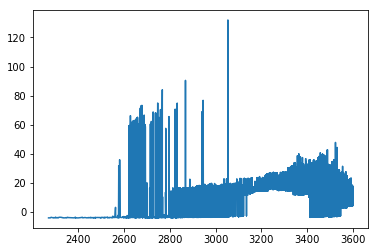

In [27]:
plt.plot(df_vis["BattV"], df_vis["SM"])

This is a very rough classification of the data. With the beginning of the battery life, all data is inliner. Between 3200 and 3000 Volt, the data will be declared as outlier, i.e. the sensors are not useful anymore. How can we develop the algorithm further? 

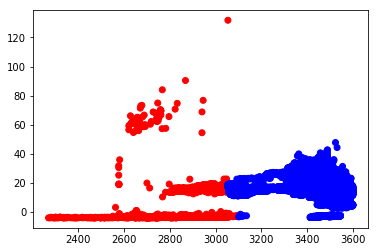

In [29]:
fig, ax = plt.subplots()
colors = {-1:'red', 1:'blue'}
ax.scatter(df_vis['BattV'], df_vis['SM'], c=df_vis['Pred'].map(colors))
plt.show()